
#**Mask R-CNN Demo and Assignment**

## **- Mask RCNN short description**

Mask RCNN is a method for instance segmentation.
 
> **Input: **Image

 >**Output: ** (1) object bonding box  (2) object mask  (3) object score


## **- Import Library**

This file already import and download all the dependencies for Mask-RCNN, just RUN from Block 1 to Block 8 you will see the output result.
Every block has the description and comments.


### **The assignment for this project will describe at the bottom.**


In [0]:
import os
import sys
import cv2
import math
import coco
import random
import colorsys
import skimage.io
import matplotlib
import numpy as np
import mrcnn.model as modellib
import matplotlib.pyplot as plt

from mrcnn import utils
from mrcnn import visualize
from matplotlib.pyplot import imshow
from matplotlib import patches,  lines
from matplotlib.patches import Polygon
from skimage.measure import find_contours


%matplotlib inline

# **Connect to google drive and link to the file**

In [174]:
from google.colab import drive
drive.mount("/content/drive/")

%cd drive/My Drive/Mask_RCNN/samples/

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-174-f6dbf6eca1f2>", line 4, in <module>
    get_ipython().magic('cd drive/My Drive/Mask_RCNN/samples/')
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2160, in magic
    return self.run_line_magic(magic_name, magic_arg_s)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2081, in run_line_magic
    result = fn(*args,**kwargs)
  File "</usr/local/lib/python3.6/dist-packages/decorator.py:decorator-gen-91>", line 2, in cd
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/magic.py", line 188, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/usr/local

OSError: ignored

In [0]:
!ls

shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
ls: cannot open directory '.': Transport endpoint is not connected


# **Function for display instance after using Mask-RCNN**

In [0]:
def display_instances(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    
    # Number of instances
    N = boxes.shape[0]
    print(N)
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Label
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            caption = "{} {:.3f}".format(label, score) if score else label
        else:
            caption = captions[i]
        ax.text(x1, y1 + 8, caption,
                color='w', size=11, backgroundcolor="none")

        # Mask
        mask = masks[:, :, i]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))
    if auto_show:
        plt.show()

# **Function for apply masks and colors**

In [0]:
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors
  
def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

# **Configurations**

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the CocoConfig class in coco.py.


In [0]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

# **Load Weight**

In [0]:
%cd ..
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir="logs", config=config)

%cd samples
# Load weights trained on MS-COCO
model.load_weights("mask_rcnn_coco.h5", by_name=True)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-168-cbe0f4c74031>", line 1, in <module>
    get_ipython().magic('cd ..')
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2160, in magic
    return self.run_line_magic(magic_name, magic_arg_s)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2081, in run_line_magic
    result = fn(*args,**kwargs)
  File "</usr/local/lib/python3.6/dist-packages/decorator.py:decorator-gen-91>", line 2, in cd
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/magic.py", line 188, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/magics/osm.py", line 288, in cd
    oldcwd = py3compat.getcwd()
OSError: [Errno 107] Transport endpoint is not connected

OSError: ignored

# **Class Names**

The model classifies objects and returns class IDs, which are integer value that identify each class. 

In [0]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']


# **Run Object Detection**

Processing 1 images
image                    shape: (437, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
2


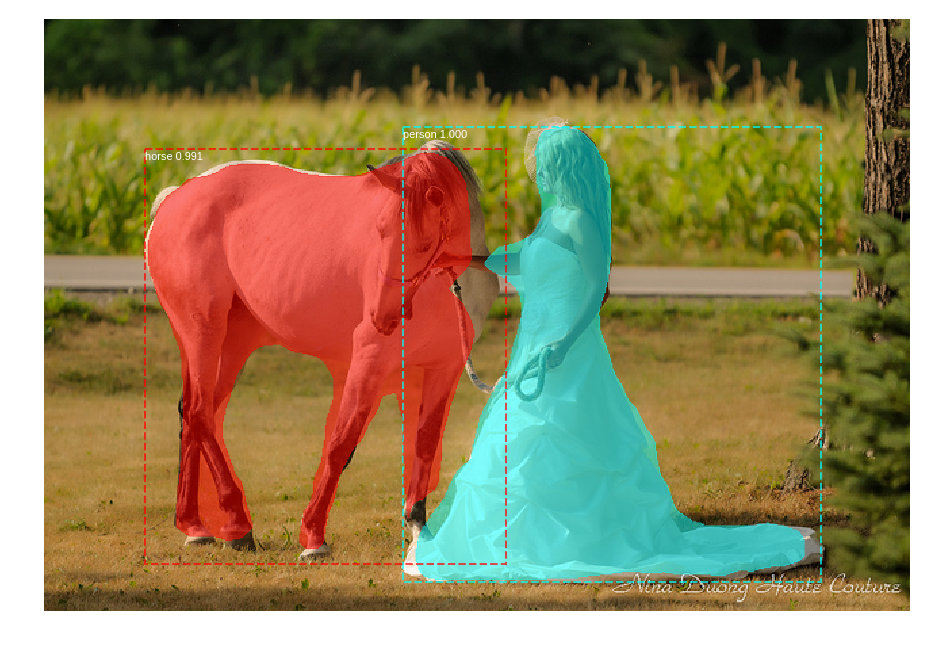

In [0]:
# Load a image from the folder
image = skimage.io.imread("sample.jpg")

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]

display_instances(image, r['rois'], r['masks'], r['class_ids'],class_names, r['scores'])

-----------------------------------------------------------------------------------------------------------
# **Assignment**

## Output the object information and seperate the masks 

### Output Object Information:

        Object number: 2

        Object 1: person
        Score: 0.9996878

        Object 2: horse
        Score: 0.99086505

-----------------------------------------------------------------------------------------------------------

### **Output Seperate Masks**

You should get the result like the output below. (Binary Mask)

-----------------------------------------------------------------------------------------------------------

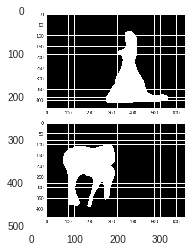

In [0]:
# Example output: seperate all the masks for the object
image = skimage.io.imread("seperate_mask.png")
plt.figure()
plt.imshow(image)

In [0]:
def ExtractMask(image, boxes, masks):
  
    N = boxes.shape[0]

    for i in range(N):
        height,width,channels = image.shape
        masked_image = np.zeros((height,width,3), np.uint8)
        color = (255,255,255)

        mask = masks[:, :, i]
        image = apply_mask(masked_image, mask, color)
        plt.figure()
        plt.imshow(image)

In [0]:
def apply_mask(image, mask, color, alpha=0.5):
    for n, c in enumerate(color):
        image[:, :, n] = np.where(
            mask == 1,
            image[:, :, n] * 0 + 255,
            image[:, :, n]
        )
    return image


In [0]:
def info():
  print("Object number: " + str(r['class_ids'].size)+"\n")

  for i in range(r['class_ids'].size):
      print("Object " + str(i+1) + ": " + class_names[r['class_ids'][i]] + "\nProbability: " + str(r['scores'][i])+"\n")
    

Object number: 2

Object 1: person
Probability: 0.9996878

Object 2: horse
Probability: 0.99086505

0
1


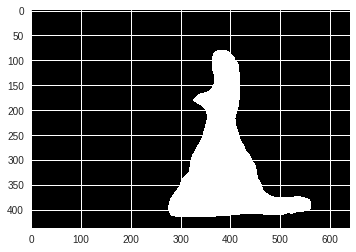

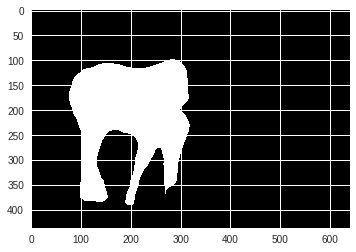

In [0]:
info()
ExtractMask(image, r['rois'], r['masks'])

# **End.**